In [1]:
import random 
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt
import library_data_science as lds

# Curve Fitting

Fitting a Polynomial Function to Data Brings Several Benefits:

* It serves as a reference model,

* It allows us to parameterize phenomena occurring in various scientific fields (physics, biology, economics),

* It becomes a good approximation of a phenomenon, enabling us to treat the model almost on par with real event outcomes.

It may seem that the higher the $R^2$ coefficient, the better the fit. This is true when analyzing a given dataset. However, in most cases, the fitted polynomial function also serves as a model for another dataset representing the same phenomenon. In such cases, an overly well-fitted curve may result in what is known as **overfitting**.

### Overfitting

For our curve to serve as a reference model for another dataset representing the same phenomenon, it should be tested on a different dataset. This can be done in two ways:

* Testing the same curve using $R^2$ for another dataset,

* Randomly selecting a subset of the tested model and evaluating $R^2$.

In both cases, the best model will be the one where the $R^2$ values are closest to the result obtained for the dataset used to create the model.

# Cross Validation

Assume we have two sets: a **training set** and a **test set**. **Cross-validation** provides a reliable estimation of model performance and helps us assess the correctness of the chosen model.

1. Fit a low-order polynomial model to the **training set**.

2. Evaluate the model on the **test set** and calculate the $R^2$ score.

3. Increase the polynomial order and repeat the process.

4. Continue until the performance on the test set starts to decline, indicating overfitting.

In [2]:
def cross_validation(X_train: list, Y_train: list, X_test: list, Y_test: list, trials = 10, display = False) -> list:
    r_square = 0
    mse = 0
    factors = []

    for n in range(1, trials + 1):
        factors_predicted = np.polyfit(X_train, Y_train, n)
        Y_predicted_test = [ lds.polynomial(x, factors_predicted) for x in X_test ]
        mse_current = lds.mse(Y_test, Y_predicted_test)
        r_square_current = lds.r_square(Y_test, Y_predicted_test)

        if r_square < r_square_current:
            mse = mse_current
            r_square = r_square_current
            factors = factors_predicted
        
        if r_square == 0:
            if mse < mse_current:
                mse = mse_current
                r_square = r_square_current
                factors = factors_predicted
        
        if display:
            X = np.linspace(min(X_test), max(X_test), num = 1000)
            Y = [ lds.polynomial(x, factors_predicted) for x in X]

            plt.scatter(X_test, Y_test)
            plt.plot(X, Y, color = 'red', label = f'n = {n}, MSE = {np.round(mse_current, 3)}, R^2 = {np.round(r_square_current, 3)}')

            plt.legend()
            plt.xlabel('X_test')
            plt.ylabel('Y_test')
            plt.show()
    
    result_factors = [ float(datum) for datum in factors ]
    result_mse = float(mse)
    result_r_square = float(r_square)
    
    return result_factors, result_mse, result_r_square, len(result_factors)


def best_cross_validation(results: tuple, by_mse = False) -> tuple:
    best = results[0]
    if by_mse:
        for result in results:
            if result[1] < best[1]:
                best = result
    else:
        for result in results:
            if result[2] > best[2]:
                best = result
    return best

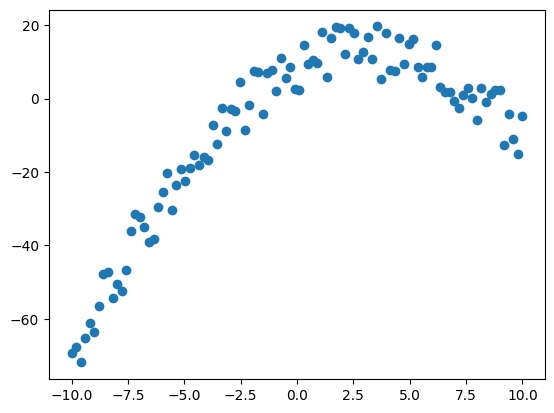

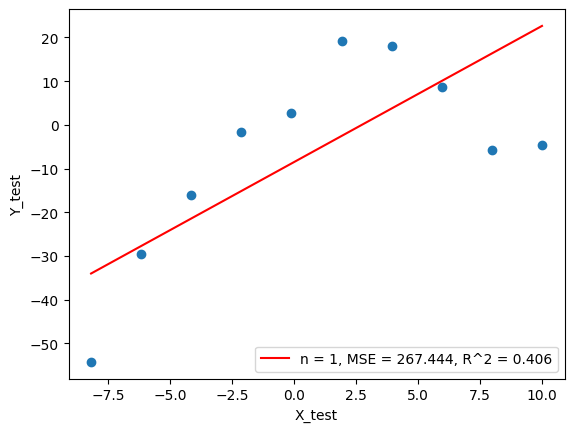

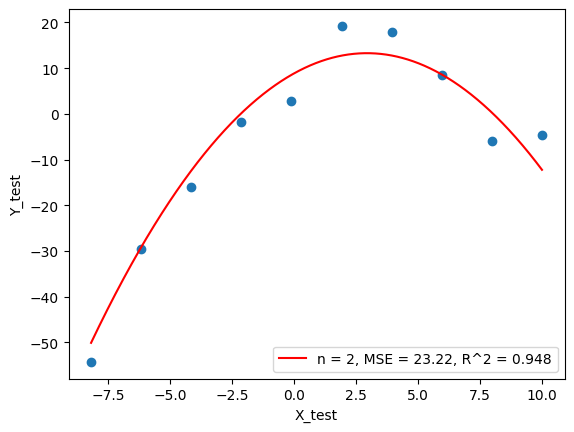

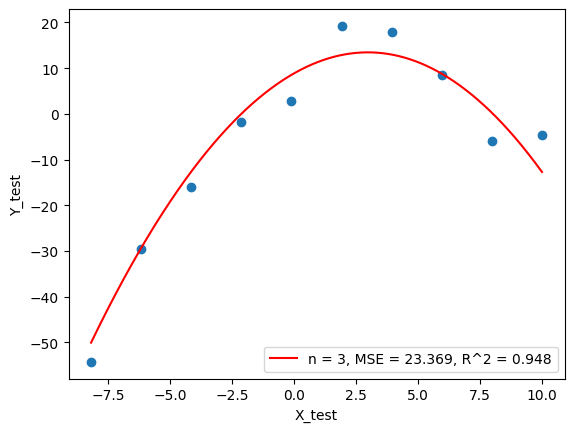

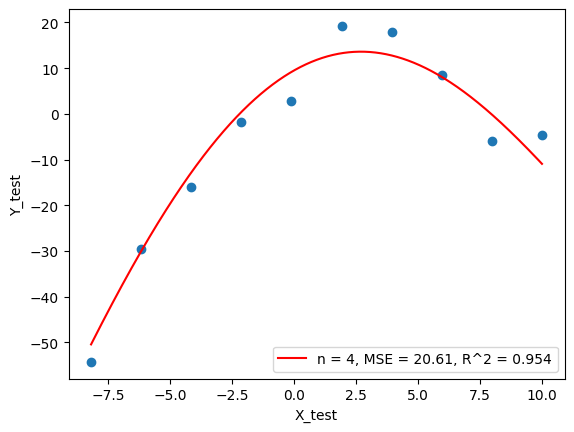

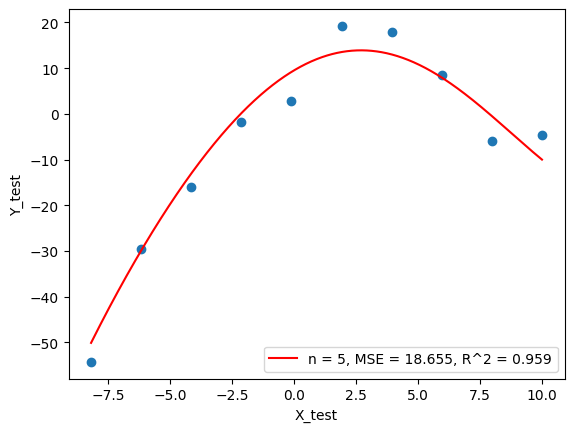

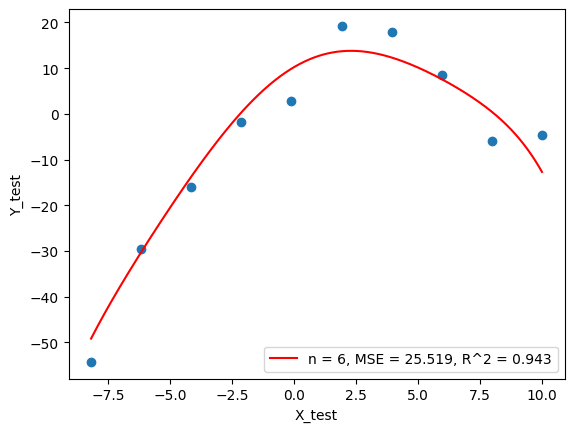

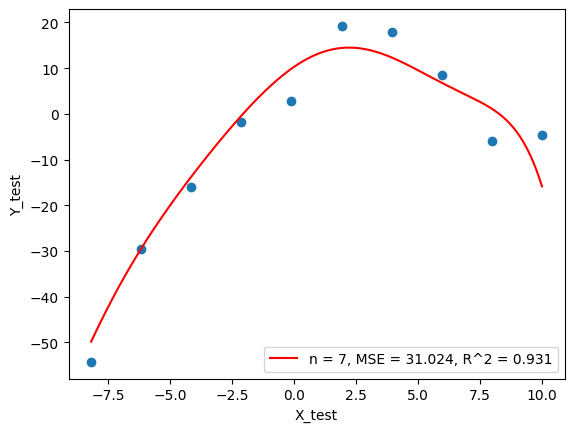

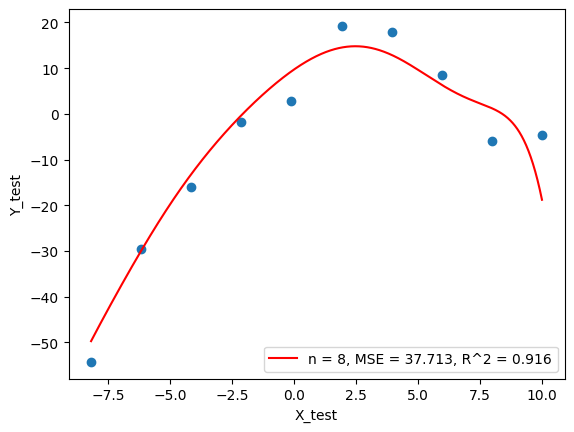

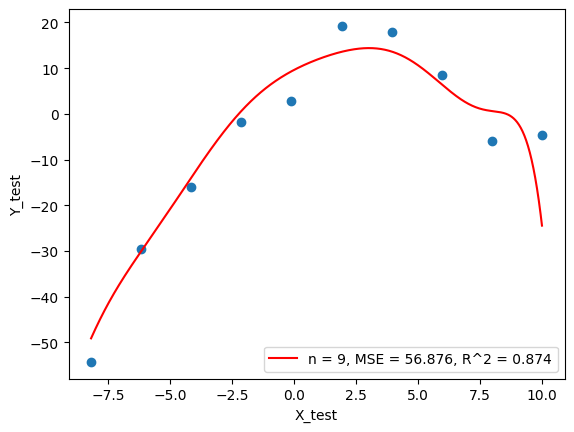

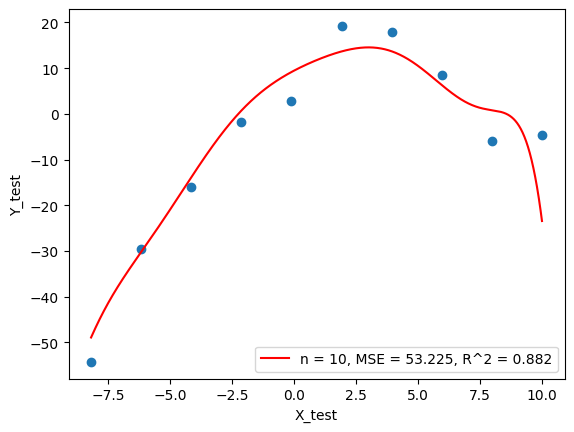

([6.560848266872774e-05, 0.000763617220600655, -0.008192620056013757, -0.5779840394838545, 3.228363165661311, 9.510329858870518], 18.654725200597422, 0.9585997501364973, 6) 4


In [3]:
X = np.linspace(-10, 10, num = 100)
Y = [ lds.polynomial(x, (-0.5, 3, 1)) + (15 * random.random()) for x in X  ]

plt.scatter(X, Y)
plt.show()

X_train = []
Y_train = []
X_test = []
Y_test = []

for i in range(len(X)):
    if (i + 1) % 10 == 0:
        X_test.append(X[i])
        Y_test.append(Y[i])
    else:
        X_train.append(X[i])
        Y_train.append(Y[i])

factors = cross_validation(X_train, Y_train, X_test, Y_test, display = True)
print(factors, len(factors))

### Leave-One-Out Cross-Validation (LOOCV)  

Leave-One-Out Cross-Validation (LOOCV) is a special case of k-fold cross-validation, where each iteration uses a single observation as the test set while the remaining data serves as the training set. This method is particularly useful for small datasets, as it maximizes data utilization.  

#### **Algorithm:**  

1. Given a dataset with $n$ observations, divide it into $n$ subsets, each containing a single observation.  

2. For each $i$ from $1$ to $n$:  

   - Use the $i$-th observation as the test set.  

   - Train the model on the remaining $n-1$ observations.  

   - Evaluate the model on the test observation and record the result.  

3. Compute the final evaluation metric by averaging the results from all iterations.  

**Advantages:**  

* **Maximizes training data usage** – Since each iteration uses almost the entire dataset for training, the model benefits from more training samples.  

* **Less bias** – Compared to k-fold cross-validation, LOOCV often provides an unbiased estimate of model performance.  

**Disadvantages:** 

* **High computational cost** – The model must be trained $n$ times, making it impractical for large datasets.  

  - **Time complexity:** $\mathcal{O}(n \cdot T)$, where $T$ is the time required to train the model once.  

  - **Memory complexity:** Depends on the model, but generally higher due to repeated training.  

* **Sensitivity to outliers** – Since each observation serves as a test case, outliers can disproportionately affect the results.  


In [4]:
def leave_one_out_cross_validation(X: list, Y: list, trials = 10, display = False) -> list:
    results = []

    for i in range(len(X)):
        X_train = []
        Y_train = []
        X_test = []
        Y_test = []

        for j in range(len(X)):
            if i == j:
                X_test.append(X[j])
                Y_test.append(Y[j])
            else:
                X_train.append(X[j])
                Y_train.append(Y[j])
        
        model = cross_validation(X_train, Y_train, X_test, Y_test, trials, display)
        
        results.append(model)
    
    return list(results)

In [5]:
loo = leave_one_out_cross_validation(X, Y)
print(best_cross_validation(loo, by_mse = True))

([3.047716373553061, -8.59124226272843], 0.14339493816382318, -inf, 2)


/Users/danielfaltynowski/Documents/Repositories/learn-data-science/library_data_science.py:321: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (residual_sum_of_squares(Y_observed, Y_predicted) / (variance(Y_observed) * len(Y_observed)))


### K-Fold Cross-Validation  

K-Fold Cross-Validation is a technique used to evaluate a model's performance by splitting the dataset into multiple subsets (folds) and training the model multiple times on different partitions of the data. It provides a good balance between training efficiency and model evaluation accuracy.  

#### **Algorithm:**  

1. Split the dataset into $k$ equally sized (or nearly equal) folds, where $k$ is a predefined number.  

2. For each $i$ from $1$ to $k$:  

   - Use the $i$-th fold as the test set.  

   - Train the model on the remaining $k-1$ folds.  

   - Evaluate the model on the test fold and record the result.  

3. Compute the final evaluation metric by averaging the results from all iterations.  

**Comparison to LOOCV:**  

K-Fold Cross-Validation is similar to Leave-One-Out Cross-Validation (LOOCV), but it is more practical for larger datasets since it reduces computational cost.  

**Advantages:**  

* **More computationally efficient than LOOCV** – The model is trained only $k$ times instead of $n$ times.  

* **Flexibility in choosing $k$** – Common values are $k=5$ or $k=10$, balancing computational efficiency and accuracy.  

**Disadvantages:**  

* **Choice of $k$ affects performance** – A small $k$ may lead to higher variance, while a large $k$ increases computational cost.  

  - **Time complexity:** $\mathcal{O}(k \cdot T)$, where $T$ is the time to train the model once.  
  
  - **Memory complexity:** Similar to a single model training run but repeated $k$ times.  


In [6]:
def k_fold_cross_validation(X: list, Y: list, k: int, trials = 10, display = False) -> list:
    results = []

    for i in range(k):
        X_train = []
        Y_train = []
        X_test = []
        Y_test = []

        for j in range(len(X)):
            if (j + i) % k == 0:
                X_test.append(X[j])
                Y_test.append(Y[j])
            else:
                X_train.append(X[j])
                Y_train.append(Y[j])
        
        model = cross_validation(X_train, Y_train, X_test, Y_test, trials, display)
        
        results.append(model)
    
    return list(results)

In [7]:
kf = k_fold_cross_validation(X, Y, 5)
print(best_cross_validation(kf))

([0.0006594234771616347, -0.003027336725413463, -0.5642267982575581, 3.2561880773516885, 9.142050259310468], 15.508873261069471, 0.9742529087010605, 5)


### Repeated Random Sampling Cross-Validation (Monte Carlo Cross-Validation)  

Repeated Random Sampling Cross-Validation, also known as Monte Carlo Cross-Validation, is a technique that repeatedly selects random subsets of data for training and testing, providing a diverse evaluation of model performance.  

#### **Algorithm:**  

1. Specify the number of iterations and the desired proportions for the training and test sets.  

2. For each iteration:  

   - Randomly split the dataset into training and test sets based on the defined proportions.  

   - Train the model on the training set.  

   - Evaluate the model on the test set and record the result.  

3. Compute the final evaluation metric by averaging the results from all iterations.  

**Advantages:**  

* **More diverse evaluation** – Since the data is split randomly in each iteration, the model is tested on different variations of the dataset.  

* **Flexible train-test split** – Unlike k-fold or LOOCV, this method allows custom proportions for training and test sets.  

**Disadvantages:**  

* **Potential underutilization of data** – Some samples may never be included in training or testing, leading to information loss.

* **Requires many iterations for reliability** – A low number of iterations may lead to unstable results, while too many increase computational cost.  

  - **Time complexity:** $O(m \cdot T)$, where $m$ is the number of iterations and $T$ is the training time per iteration.  

  - **Memory complexity:** Similar to training a single model but repeated $m$ times.  


In [8]:
def repeated_random_sampling(X: list, Y: list, num_samples: int, sample_size: int, trials = 10, display = False) -> list:
    results = []

    for i in range(num_samples):
        indexes = random.sample(list(range(len(X))), sample_size)

        X_test = []
        Y_test = []
        X_train = []
        Y_train = []

        for j in range(len(X)):
            if j in indexes:
                X_test.append(X[j])
                Y_test.append(Y[j])
            else:
                X_train.append(X[j])
                Y_train.append(Y[j])
        
        model = cross_validation(X_train, Y_train, X_test, Y_test, trials, display)
        
        results.append(model)
    
    return list(results)

In [9]:
rr = repeated_random_sampling(X, Y, 5, 50)
print(best_cross_validation(rr))

([5.231173542772753e-05, 0.0009264820838766634, -0.0028667728609692656, -0.5749450481016684, 2.957725182454219, 9.171951106600243], 18.767072618130882, 0.9718560579785506, 6)


| **Method**                         | **Description**                                                                                      | **Advantages**                                                      | **Disadvantages**                                                | **Time Complexity**      | **Memory Complexity**      |
|------------------------------------|------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------|-----------------------------------------------------------------|--------------------------|----------------------------|
| **Leave-One-Out Cross-Validation (LOOCV)** | Each observation is used as the test set, and the remaining data is used for training. The process is repeated for all observations. | ✔ Maximizes data usage for training.<br>✔ Less biased estimate of performance. | ✖ High computational cost (model trained $n$ times).<br>✖ Sensitive to outliers. | $O(n \cdot T)$, where $T$ is training time per model. | Higher due to repeated training. |
| **K-Fold Cross-Validation**       | The dataset is split into $k$ folds. Each fold is used as a test set once, with the remaining folds used for training. | ✔ More computationally efficient than LOOCV.<br>✔ Flexible choice of $k$. | ✖ Choice of $k$ affects accuracy and cost.<br>✖ Higher computational cost for large $k$. | $O(k \cdot T)$, where $T$ is training time per fold. | Similar to training once, repeated $k$ times. |
| **Repeated Random Sampling Cross-Validation (Monte Carlo CV)** | Randomly selects subsets of data multiple times for training and testing. | ✔ Diverse evaluation with different data configurations.<br>✔ Flexible train-test proportions. | ✖ Data may be underused in training or testing.<br>✖ Requires many iterations for reliable results. | $O(m \cdot T)$, where $m$ is the number of iterations and $T$ is training time per iteration. | Similar to training once, repeated $m$ times. |


**Wrapping Up Curve Fitting!**

* Linear regression can be used to fit a curve to data.

* The curve acts as a model of the data, which can predict values for unseen independent variables.

* $R^2$ is used to evaluate the model.

* Choose the model complexity based on:

    - Theoretical understanding of the data's structure.
    
    - Cross-validation.
    
    - Simplicity.
